# Tesla Stock Price and Forecasting
This project use tesla's stock price data to predict and forecast future stock price using a deep learning technique, ***Stacked LSTM***.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")

In [9]:
df = pd.read_csv("./data/TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,719.460022,744.489990,717.190002,729.770020,729.770020,48638200
1,2021-01-05,723.659973,740.840027,719.200012,735.109985,735.109985,32245200
2,2021-01-06,758.489990,774.000000,749.099976,755.979980,755.979980,44700000
3,2021-01-07,777.630005,816.989990,775.200012,816.039978,816.039978,51498900
4,2021-01-08,856.000000,884.489990,838.390015,880.020020,880.020020,75055500


Its required to transform `Date` column to ***datetime*** object to be able to analyze the data and forecasting.

In [12]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,719.460022,744.489990,717.190002,729.770020,729.770020,48638200
1,2021-01-05,723.659973,740.840027,719.200012,735.109985,735.109985,32245200
2,2021-01-06,758.489990,774.000000,749.099976,755.979980,755.979980,44700000
3,2021-01-07,777.630005,816.989990,775.200012,816.039978,816.039978,51498900
4,2021-01-08,856.000000,884.489990,838.390015,880.020020,880.020020,75055500


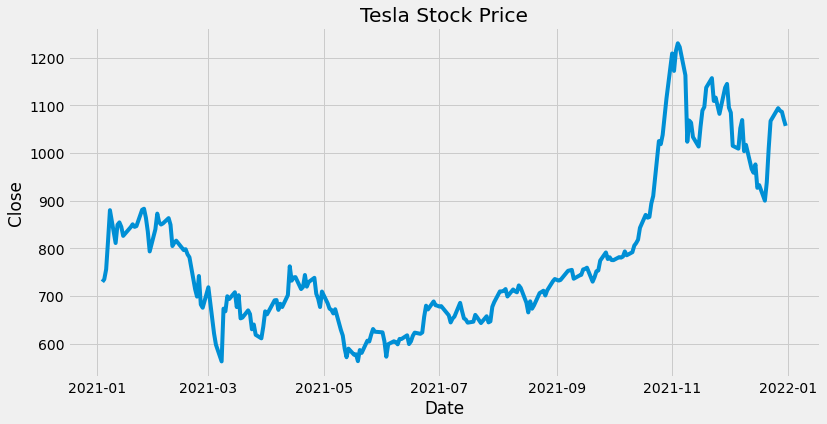

In [34]:
plt.figure(figsize=([12,6]))
sns.lineplot(data = df, x = 'Date', y = 'Close')
plt.title("Tesla Stock Price")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

In [15]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Now that the dtype was changed, we can set the indexes of the dataframe equal to `Date` column, this is done to be able to work easily with some tools for time series.

In [17]:
df.set_index(df['Date'], inplace=True)
df.drop("Date", axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,719.460022,744.489990,717.190002,729.770020,729.770020,48638200
2021-01-05,723.659973,740.840027,719.200012,735.109985,735.109985,32245200
2021-01-06,758.489990,774.000000,749.099976,755.979980,755.979980,44700000
2021-01-07,777.630005,816.989990,775.200012,816.039978,816.039978,51498900
2021-01-08,856.000000,884.489990,838.390015,880.020020,880.020020,75055500


## Scaling Data
LSTM is very sensitive to the scale of data, for this reason i'm going to use StandardScaler to scaled `Close` column.

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
df_close = df['Close']
scaler = StandardScaler()
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [26]:
df_close[:5]

array([[-0.31215158],
       [-0.278963  ],
       [-0.14925326],
       [ 0.22402746],
       [ 0.62167176]])

## Train/Test Split
Since we are working with time series forecasting we can't split our data randomly, we need to keep the same data order when making the split. 

In [27]:
train_size = int(len(df_close)*0.7)
test_size = int(len(df_close)-train_size)
train, test = df_close[0:train_size, :], df_close[train_size:len(df_close), :]

In [29]:
print("---- Train/Test Shape ----")
print("Train:", len(train))
print("Test:", len(test))

---- Train/Test Shape ----
Train: 176
Test: 76


In [38]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [137]:
time_step = 5
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [138]:
print("X_train shape:",X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (170, 5)
y_train shape: (170,)


In [139]:
print("X_test shape:",X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (70, 5)
y_test shape: (70,)


Reshape input to be [samples, time_steps, features] which is required for LSTM.

In [140]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Create LSTM Model

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [141]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(5,1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

In [142]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [131]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 50, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
3/3 [==============================] - 4s 393ms/step - loss: 0.4737 - val_loss: 2.1975
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3940 - val_loss: 2.0985
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3153 - val_loss: 1.9876
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.2231 - val_loss: 1.8583
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1330 - val_loss: 1.7117
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0918 - val_loss: 1.5674
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.1140 - val_loss: 1.4799
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1037 - val_loss: 1.4455
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0774 - val_loss: 1.4234
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0746 - val_loss: 1.3821
Epoch 11/100
3/3 [

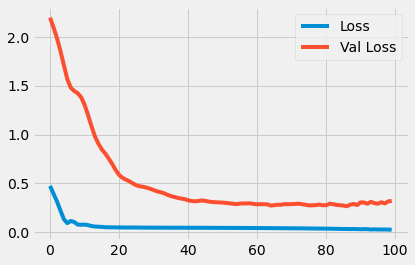

In [144]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='best')
plt.show()

In [83]:
import tensorflow as tf

Let's do the predictions and check performance metrics

In [145]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Transform the prediction to original form

In [146]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Calculate Root Mean Squared Error (RMSE)

In [147]:
import math
from sklearn.metrics import mean_squared_error
print("Train RMSE:",(math.sqrt(mean_squared_error(y_train, train_predict))))
print("Test RMSE:",(math.sqrt(mean_squared_error(y_test, test_predict))))

Train RMSE: 699.1489213328733
Test RMSE: 923.6633336413497


Plotting Predictions

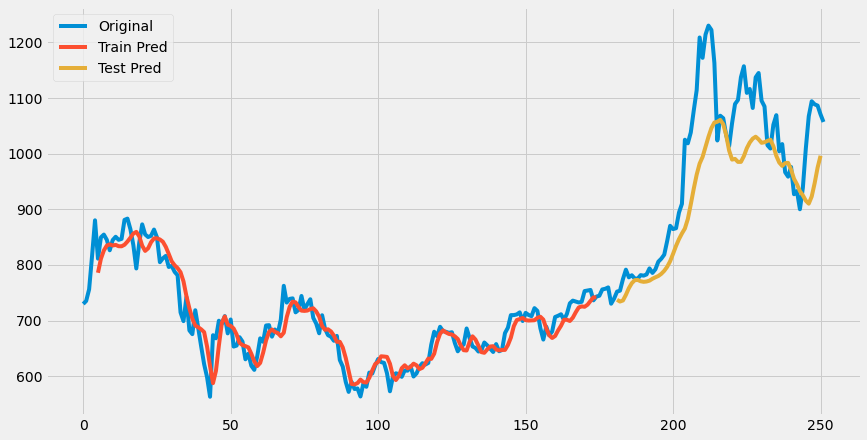

In [149]:
plt.figure(figsize=([13,7]))
look_back=5
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close), label='Original')
plt.plot(trainPredictPlot, label='Train Pred')
plt.plot(testPredictPlot, label='Test Pred')
plt.legend(loc='best')
plt.show()

It's a very good result considering that we have a very low number of data (253 observations). We can improve the model if we try to get more data about the stock for example data from 3 year or 1 year but for each hour.

## Predict the next 30 days stock price

We train the model with the previous 10 days (time_steps). So to predict future days we need to take in count the previous 10 days.

In [150]:
len(test)

76

In [151]:
x_input = test[71:].reshape(1,-1)
x_input.shape

(1, 5)

In [152]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [153]:
lst_output=[]
n_steps=5
i=0
while(i<30):
    
    if(len(temp_input)>5):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.4203448]
6
1 day input [1.91721537 1.90304469 1.80453503 1.72025825 1.42034483]
1 day output [[1.3919095]]
2 day input [1.90304469 1.80453503 1.72025825 1.42034483 1.39190948]
2 day output [[1.3434591]]
3 day input [1.80453503 1.72025825 1.42034483 1.39190948 1.34345913]
3 day output [[1.2699826]]
4 day input [1.72025825 1.42034483 1.39190948 1.34345913 1.26998258]
4 day output [[1.1880946]]
5 day input [1.42034483 1.39190948 1.34345913 1.26998258 1.18809462]
5 day output [[1.1168209]]
6 day input [1.39190948 1.34345913 1.26998258 1.18809462 1.11682093]
6 day output [[1.0804254]]
7 day input [1.34345913 1.26998258 1.18809462 1.11682093 1.08042538]
7 day output [[1.0346026]]
8 day input [1.26998258 1.18809462 1.11682093 1.08042538 1.03460264]
8 day output [[0.98620826]]
9 day input [1.18809462 1.11682093 1.08042538 1.03460264 0.98620826]
9 day output [[0.94288296]]
10 day input [1.11682093 1.08042538 1.03460264 0.98620826 0.94288296]
10 day output [[0.9065728]]
11 day input [1.080425

In [161]:
day_new=np.arange(1,31)
day_pred=np.arange(31,61)

In [158]:
len(df_close)

252

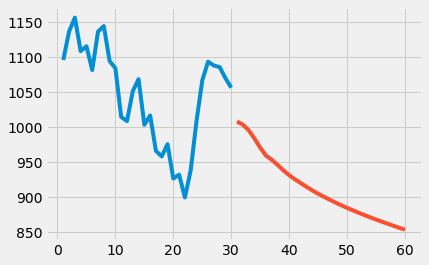

In [163]:
plt.plot(day_new,scaler.inverse_transform(df_close[222:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))